## Print the final results

In [1]:
import os
import json
import pandas as pd

'''
{baseline_tag: 
    { 
        eval_dataset:{ }
                        
    }
}
'''

all_results = {}  

### full results print ####

# baseline_tags = ['random', 'diversity', 'label', 'filtered']
# eval_dataset_lists = ['mmlu', 'bbh',  'tydiqa', 'gsm', 'truthfulqa', 'codex_humaneval']
# eval_metrics = ['average_acc', 'average_exact_match',  "average""f1", "exact_match", "truth-info acc", "pass@10" ]


root_result_path = 'logs-llama3.1-8b/evaluation_result/results'

# Baseline tags and datasets
train_dataset = 'all_train'

# base_model ='meta-llama/Llama-2-7b-hf'
base_model ="meta-llama/Meta-Llama-3.1-8B" 
# base_model='mistralai/Mistral-7B-v0.3'


# labeling_model="meta-llama/Meta-Llama-3.1-8B-Instruct"
# labeling_model="gpt-4o-mini"
labeling_model='mistralai/Mistral-7B-Instruct-v0.3'



eval_dataset_lists = ['mmlu', 'truthfulqa', 'gsm', 'bbh', 'tydiqa' ]
# baseline_tags=['base','random',  'completion', 'perplexity',  'knn',  'label-filtered', 'diversity-filtered', 'less', 'filtered', 'full'] #baselines

baseline_tags=[ 'label-filtered', 'diversity-filtered', 'filtered'] #baselines

# Load results from JSON files
for tag in baseline_tags:
    baseline_results = {}
    for eval_dataset in eval_dataset_lists:
        path = root_result_path + f'/{labeling_model}/{train_dataset}/{eval_dataset}/{base_model}/{tag}/metrics.json'
        try:
            with open(path, 'r') as f:
                json_file = json.load(f)
            baseline_results[eval_dataset] = json_file
        except FileNotFoundError:
            print(f"Failed to find the file at {path}")
            baseline_results[eval_dataset] = None

    all_results[tag] = baseline_results

# Extract relevant metrics and store in a DataFrame
cur_results = {}
for tag in baseline_tags:
    baseline_result = []
    for eval_dataset in eval_dataset_lists:
        if all_results[tag][eval_dataset] is None:
            value = None
        else:
            if eval_dataset == 'mmlu':
                value = round(all_results[tag][eval_dataset]['average_acc'] * 100, 1)
            elif eval_dataset == 'bbh':
                value = round(all_results[tag][eval_dataset]['average_exact_match']* 100, 1)
            elif eval_dataset == 'tydiqa':
                value = round(all_results[tag][eval_dataset]['average']['f1'], 1)
            elif eval_dataset == 'gsm':
                value = round(all_results[tag][eval_dataset]['exact_match']* 100, 1)
            elif eval_dataset == 'truthfulqa':
                value = round(all_results[tag][eval_dataset]["truth-info acc"]* 100, 1)
            else:
                print("unknown eval dataset!")


        baseline_result.append(value)
    cur_results[tag] = baseline_result

# Convert cur_results to pandas DataFrame
df_results = pd.DataFrame.from_dict(cur_results, orient='index', columns=eval_dataset_lists)

# Calculate the average accuracy for each baseline
df_results['average acc'] = df_results.mean(axis=1).round(1)
print(f"### base_model: {base_model}")
print(f"### labeling_model: {labeling_model}")
print(df_results)


### base_model: mistralai/Mistral-7B-v0.3
### labeling_model: mistralai/Mistral-7B-Instruct-v0.3
                    mmlu  truthfulqa   gsm   bbh  tydiqa  average acc
label-filtered      59.1        39.5  46.0  53.2    53.9         50.3
diversity-filtered  60.1        36.5  42.5  56.8    54.6         50.1
filtered            59.5        40.4  43.0  51.4    49.8         48.8


### Contatenate labels from API Calling

In [2]:
import torch 


dataset_name = 'oasst1'
file_path = f'./logs-api/gpt-4o-mini/{dataset_name}/'
idxs=34

tot_labels = []
for idx in range(idxs):
    batch_labels =  torch.load(file_path + f"output_labels_{idx}.pt")
    tot_labels.extend(batch_labels)

tot_labels = [label if label is not None else [0, 0, 0, 0] for label in tot_labels]


torch.save(tot_labels, file_path + "total_output_labels.pt")


/tmp/ipykernel_66846/98561513.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  batch_labels =  torch.load(file_path + f"output_labels_{idx}.pt")


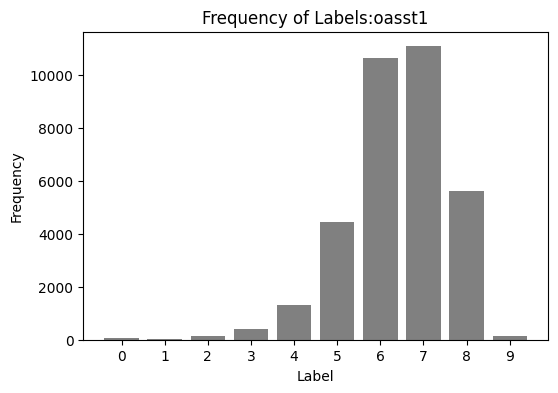

In [4]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

counter = Counter(np.array(tot_labels)[:,-1].tolist())


labels, counts = zip(*counter.items())

plt.figure(figsize=(6, 4))
plt.bar(labels, counts, color='gray')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.title(f'Frequency of Labels:{dataset_name}')
plt.xticks(labels)  
plt.show()

### Concatenate GPT_Labeling

Dataset flan_v2 size: 100000 -- : Revised Counter({2: 36454, 3: 35613, 1: 15071, 4: 8112, 0: 4645, 5: 105}) 

Dataset oasst1 size: 33919 -- : Revised Counter({3: 11093, 2: 10665, 4: 5620, 1: 4457, 0: 1932, 5: 152}) 

Dataset wizardlm size: 100000 -- : Revised Counter({4: 43489, 3: 29644, 2: 15177, 1: 5586, 5: 3483, 0: 2621}) 

Dataset dolly size: 15011 -- : Revised Counter({2: 5212, 3: 3608, 1: 3314, 4: 1656, 0: 1154, 5: 67}) 

Dataset stanford_alpaca size: 52002 -- : Revised Counter({2: 18624, 1: 15973, 0: 8274, 3: 8017, 4: 1092, 5: 22}) 

总共加载了 300932 个标签。
total count: Counter({3: 87975, 2: 86132, 4: 59969, 1: 44401, 0: 18626, 5: 3829})


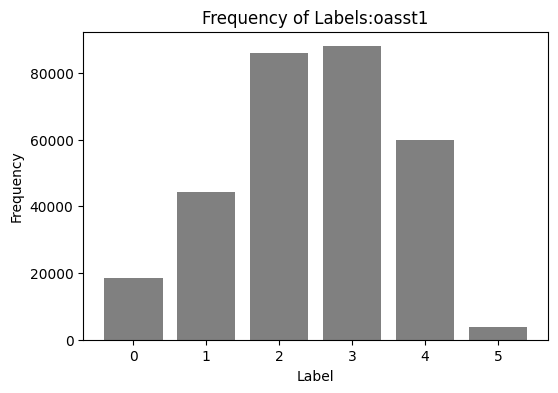

In [84]:
import os
import torch
from collections import Counter
from datasets import load_dataset, concatenate_datasets, Dataset
import matplotlib.pyplot as plt

# 定义数据集列表
DATASET_LIST = ['flan_v2', 'oasst1', 'wizardlm', 'dolly', 'stanford_alpaca']



# 定义主目录路径
base_dir = f'./logs-api/gpt-4o-mini-2024-08-28'


# 用于保存所有数据的列表
all_labels = []

# 遍历每个数据集
for dataset in DATASET_LIST:
    labels_path = os.path.join(base_dir, dataset, 'total_output_labels.pt')
    
    if os.path.exists(labels_path):
        # 加载并扩展文件内容
        original_labels = torch.load(labels_path)
        original_labels = [label[-1] for label in original_labels]
        labels_revised = []
        for label in original_labels:
            if label < 4:
                labels_revised.append(4)
            elif label >= 10:
                labels_revised.append(9)
            else:
                labels_revised.append(label)

        labels_revised = [label - 4 for label in labels_revised] #rematching

        label_counts_revised = Counter(labels_revised)
        print(f"Dataset {dataset} size: {len(labels_revised)} -- : Revised {label_counts_revised} \n")

        all_labels.extend(labels_revised)

    else:
        print(f"Cannot found the {labels_path}")

# 打印或处理汇总后的标签数据
print(f"总共加载了 {len(all_labels)} 个标签。")


if not os.path.exists(base_dir + f"/all_train/"):
    os.mkdir(base_dir + f"/all_train/")

torch.save(all_labels, base_dir + f"/all_train/total_output_labels.pt")

import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

counter = Counter(all_labels)
print(f"total count: {counter}")

labels, counts = zip(*counter.items())

# 绘制柱状图
plt.figure(figsize=(6, 4))
plt.bar(labels, counts, color='gray')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.title(f'Frequency of Labels:{dataset_name}')
plt.xticks(labels)  # 显示所有的标签
plt.show()



In [12]:
import torch
from collections import defaultdict
import random
import numpy as np

seed = 3
random.seed(3)
np.random.seed(3)

#llama labels
model_full_name ='meta-llama/Meta-Llama-3.1-8B-Instruct/'
new_train_dir = f"./zzzz_finetune_model/new_train_data/{model_full_name}"
output_file = os.path.join(new_train_dir, 'all_train/output_labels_revised.pt')
llama_labels= torch.load(output_file)


llama_labels_dict = defaultdict(list)
for index, label in enumerate(llama_labels):
    llama_labels_dict[label].append(index)


##GPT 4o-mini labels
base_dir = f'./logs-api/gpt-4o-mini'
gpt_labels = torch.load(base_dir + f"/all_train/total_output_labels.pt")


gpt_labels_dict = defaultdict(list)
for index, label in enumerate(gpt_labels):
    gpt_labels_dict[label].append(index)

#mistral labels
model_full_name='mistralai/Mistral-7B-Instruct-v0.3'
new_train_dir = f"./zzzz_finetune_model/new_train_data/{model_full_name}"
output_file = os.path.join(new_train_dir, 'all_train/output_labels_revised.pt')
mistral_labels= torch.load(output_file)


mistral_labels_dict = defaultdict(list)
for index, label in enumerate(mistral_labels):
    mistral_labels_dict[label].append(index)



intersection_all_dict = {}

for label in [5,4,3,2,1]:
    intersection_gpt_llama = set(gpt_labels_dict[label]) & set(llama_labels_dict[label])
    intersection_gpt_mistral = set(gpt_labels_dict[label]) & set(mistral_labels_dict[label])
    intersection_llama_mistral = set(llama_labels_dict[label]) & set(mistral_labels_dict[label])
    intersection_all_dict[label] = intersection_gpt_llama & intersection_gpt_mistral & intersection_llama_mistral
    print(f"intersection_all: {len(intersection_all_dict[label])} --- intersection_gpt_llama size: {len(intersection_gpt_llama)} -- intersection_gpt_mistral size: {len(intersection_gpt_mistral)} -- intersection_llama_mistral size:{len(intersection_llama_mistral)}")


dataset_size = 10000
combined_label_indices = set(llama_labels_dict[5] + mistral_labels_dict[5] + gpt_labels_dict[5])

additional_label_indices = random.sample(intersection_all_dict[4], dataset_size-len(combined_label_indices))


ideal_label_indices = list(combined_label_indices) + additional_label_indices




intersection_all: 10 --- intersection_gpt_llama size: 229 -- intersection_gpt_mistral size: 118 -- intersection_llama_mistral size:36
intersection_all: 12777 --- intersection_gpt_llama size: 22038 -- intersection_gpt_mistral size: 30098 -- intersection_llama_mistral size:22828
intersection_all: 16905 --- intersection_gpt_llama size: 36791 -- intersection_gpt_mistral size: 38831 -- intersection_llama_mistral size:49473
intersection_all: 4692 --- intersection_gpt_llama size: 16237 -- intersection_gpt_mistral size: 22525 -- intersection_llama_mistral size:12682
intersection_all: 2661 --- intersection_gpt_llama size: 11576 -- intersection_gpt_mistral size: 9146 -- intersection_llama_mistral size:9712


In [18]:
from datasets import load_dataset
import random
import numpy as np

seed =3
random.seed(seed)
np.random.seed(seed)

#### 
dataset_size = 10000
dataset_name ='all_train'
model_name="meta-llama/Meta-Llama-3.1-8B-Instruct"


json_dir = './data/train_data/'

all_train_dataset = load_dataset('json', data_files=json_dir+'all_train_data.jsonl')['train']




random_indices = np.random.permutation(len(all_train_dataset))[:dataset_size]

random_dataset = all_train_dataset.select(ideal_label_indices)

root_path = f"./zzzz_finetune_model/new_train_data/{model_name}/{dataset_name}/"

random_dataset.to_json(root_path + f"combined_dataset.json")


In [19]:
len(ideal_label_indices)

10000

In [14]:
len(combined_label_indices)

8050

In [12]:
from collections import Counter


Counter(mistral_labels)

Counter({3: 118313, 2: 60607, 1: 52908, 4: 66181, 0: 2436, 5: 487})

In [19]:
import os
import json
import pandas as pd
import fire
'''
{baseline_tag: 
    { 
        eval_dataset:{ }
                        
    }
}
'''

def main(
        root_result_path = 'data_scale_result_seed43',
        train_dataset='all_train',
        base_model = "meta-llama/Meta-Llama-3.1-8B",
        labeling_model='mistralai/Mistral-7B-Instruct-v0.3',
        baseline_tag = 'filtered', 
        ):

    all_results = {}  

    ### full results print ####

    labeling_models = ["meta-llama/Meta-Llama-3.1-8B-Instruct","gpt-4o-mini", 'mistralai/Mistral-7B-Instruct-v0.3']
    final_df_pivot = pd.DataFrame()  # 用于存储所有拼接的结果

    for labeling_model in labeling_models:
        # labeling_model ="meta-llama/Meta-Llama-3.1-8B-Instruct" 
        # # labeling_model="gpt-4o-mini"
        # labeling_model='mistralai/Mistral-7B-Instruct-v0.3'


        # baseline_tags=['base','random',  'completion', 'perplexity',  'knn',  'label-filtered', 'diversity-filtered', 'less', 'filtered', 'full'] #baselines
        data_scales = ['2k', '5k', '10k', '20k', '40k']


        if 'llama' in labeling_model.lower():
            baseline_tags=['random', 'less', 'label-filtered', 'diversity-filtered', 'filtered', 'filtered-cured-0.4'] ##llama
        else:
            baseline_tags=['label-filtered', 'diversity-filtered', 'filtered', 'filtered-cured-0.5'] ##llama

        # baseline_tags=['random', 'less', 'filtered'] 

        eval_dataset_lists = ['mmlu', 'truthfulqa', 'gsm', 'bbh', 'tydiqa' ]

        # Load results from JSON files
        for tag in baseline_tags:
            for data_scale in data_scales:
                baseline_results = {}
                for eval_dataset in eval_dataset_lists:
                    path = root_result_path + f'/results/{labeling_model}/{train_dataset}/{eval_dataset}/{base_model}/{tag}-{data_scale}/metrics.json'
                    try:
                        with open(path, 'r') as f:
                            json_file = json.load(f)
                        baseline_results[eval_dataset] = json_file
                    except FileNotFoundError:
                        print(f"Failed to find the file at {path}")
                        baseline_results[eval_dataset] = None

                all_results[f'{tag}-{data_scale}'] = baseline_results

        # Extract relevant metrics and store in a DataFrame
        cur_results = {}
        for tag in baseline_tags:
            for data_scale in data_scales:
                baseline_result = []
                baseline_name=f'{tag}-{data_scale}'
                for eval_dataset in eval_dataset_lists:
                    if all_results[baseline_name][eval_dataset] is None:
                        value = 0
                    else:
                        if eval_dataset == 'mmlu':
                            value = round(all_results[baseline_name][eval_dataset]['average_acc'] * 100, 1)
                        elif eval_dataset == 'bbh':
                            value = round(all_results[baseline_name][eval_dataset]['average_exact_match']* 100, 1)
                        elif eval_dataset == 'tydiqa':
                            value = round(all_results[baseline_name][eval_dataset]['average']['f1'], 1)
                        elif eval_dataset == 'gsm':
                            value = round(all_results[baseline_name][eval_dataset]['exact_match']* 100, 1)
                        elif eval_dataset == 'truthfulqa':
                            value = round(all_results[baseline_name][eval_dataset]["truth-info acc"]* 100, 1)
                        else:
                            print("unknown eval dataset!")


                    baseline_result.append(value)
                cur_results[baseline_name] = baseline_result

        # Convert cur_results to pandas DataFrame
        df_results = pd.DataFrame.from_dict(cur_results, orient='index', columns=eval_dataset_lists)

        # Calculate the average accuracy for each baseline
        df_results['average acc'] = df_results.mean(axis=1).round(1)

        # print(df_results['average acc'])
        print(f"### base_model: {base_model}")
        print(f"### labeling_model: {labeling_model}")


        # Ensure full display of the DataFrame
        pd.set_option('display.max_rows', None)  # Show all rows
        pd.set_option('display.max_columns', None)  # Show all columns
        pd.set_option('display.width', 1000)  # Set display width
        pd.set_option('display.max_colwidth', None)  # Set max column width

        # print(df_results)

        df_avg_acc = df_results['average acc']

        # Split the index into baseline_tags and data_scales
        df_avg_acc.index = pd.MultiIndex.from_tuples([idx.rsplit('-', 1) for idx in df_avg_acc.index], names=['baseline_tag', 'data_scale'])

        # Pivot the table to get baseline_tags as rows and data_scales as columns
        df_pivot = df_avg_acc.unstack(level='data_scale')
        df_pivot = df_pivot.reindex(index=baseline_tags, columns=data_scales)

        # Ensure full display of the DataFrame
        pd.set_option('display.max_rows', None)  # Show all rows
        pd.set_option('display.max_columns', None)  # Show all columns
        pd.set_option('display.width', 1000)  # Set display width
        pd.set_option('display.max_colwidth', None)  # Set max column width

        # 输出结果
        print(df_pivot)



if __name__ == '__main__':
    fire.Fire(main)


### base_model: meta-llama/Meta-Llama-3.1-8B
### labeling_model: meta-llama/Meta-Llama-3.1-8B-Instruct
data_scale            2k    5k   10k   20k   40k
baseline_tag                                    
random              54.5  54.1  57.8  56.4  56.9
less                49.1  53.3  57.7  58.6  57.2
label-filtered      45.2  48.0  46.8  52.8  54.1
diversity-filtered  49.6  50.7  56.0  56.9  56.4
filtered            57.7  57.0  58.7  58.7  58.0
filtered-cured-0.4  58.0  58.4  60.1  60.6  58.6


ERROR: Could not consume arg: --f=/home/azureuser/.local/share/jupyter/runtime/kernel-v2-205297bVV4qlmnWla5.json
Usage: ipykernel_launcher.py -

For detailed information on this command, run:
  ipykernel_launcher.py - --help


FireExit: 2

/anaconda/envs/new_env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [20]:
import os
import json
import pandas as pd
import fire

def main(
        seed=43,
        root_result_path='./data_scale_results/result_seed',
        train_dataset='all_train',
        base_model="meta-llama/Meta-Llama-3.1-8B",
        labeling_model='mistralai/Mistral-7B-Instruct-v0.3',
    ):


    root_result_path = root_result_path + str(seed)
    all_results = {}  

    ### full results extraction from result json files ####

    labeling_models = ["meta-llama/Meta-Llama-3.1-8B-Instruct", "gpt-4o-mini", 'mistralai/Mistral-7B-Instruct-v0.3']

    final_df_pivot = pd.DataFrame()  

    for labeling_model in labeling_models:

        data_scales = ['2k', '5k', '10k', '20k', '40k']


        if 'llama' in labeling_model.lower():
            baseline_tags = ['random', 'less', 'label-filtered', 'diversity-filtered', 'filtered', 'filtered-cured-0.4']  
        else:
            baseline_tags = ['label-filtered', 'diversity-filtered', 'filtered', 'filtered-cured-0.5']  

        eval_dataset_lists = ['mmlu', 'truthfulqa', 'gsm', 'bbh', 'tydiqa']

        # load results from json files
        for tag in baseline_tags:
            for data_scale in data_scales:
                baseline_results = {}
                for eval_dataset in eval_dataset_lists:
                    path = root_result_path + f'/results/{labeling_model}/{train_dataset}/{eval_dataset}/{base_model}/{tag}-{data_scale}/metrics.json'
                    try:
                        with open(path, 'r') as f:
                            json_file = json.load(f)
                        baseline_results[eval_dataset] = json_file
                    except FileNotFoundError:
                        print(f"Failed to find the file at {path}")
                        baseline_results[eval_dataset] = None

                all_results[f'{tag}-{data_scale}'] = baseline_results

        cur_results = {}
        for tag in baseline_tags:
            for data_scale in data_scales:
                baseline_result = []
                baseline_name = f'{tag}-{data_scale}'
                for eval_dataset in eval_dataset_lists:
                    if all_results[baseline_name][eval_dataset] is None:
                        value = 0
                    else:
                        if eval_dataset == 'mmlu':
                            value = round(all_results[baseline_name][eval_dataset]['average_acc'] * 100, 1)
                        elif eval_dataset == 'bbh':
                            value = round(all_results[baseline_name][eval_dataset]['average_exact_match'] * 100, 1)
                        elif eval_dataset == 'tydiqa':
                            value = round(all_results[baseline_name][eval_dataset]['average']['f1'], 1)
                        elif eval_dataset == 'gsm':
                            value = round(all_results[baseline_name][eval_dataset]['exact_match'] * 100, 1)
                        elif eval_dataset == 'truthfulqa':
                            value = round(all_results[baseline_name][eval_dataset]["truth-info acc"] * 100, 1)
                        else:
                            print("Unknown eval dataset!")

                    baseline_result.append(value)
                cur_results[baseline_name] = baseline_result

        df_results = pd.DataFrame.from_dict(cur_results, orient='index', columns=eval_dataset_lists)

        df_results['average acc'] = df_results.mean(axis=1).round(1)

        df_results.index = pd.MultiIndex.from_tuples([idx.rsplit('-', 1) for idx in df_results.index], names=['baseline_tag', 'data_scale'])

        df_pivot = df_results['average acc'].unstack(level='data_scale')
        df_pivot = df_pivot.reindex(index=baseline_tags, columns=data_scales)

        df_pivot['labeling_model'] = labeling_model.split('/')[-1]
        df_pivot = df_pivot.set_index('labeling_model', append=True)

        final_df_pivot = pd.concat([final_df_pivot, df_pivot])


    final_df_pivot['0k'] = 46.6
    final_df_pivot['300k'] = 57.7

    cols = ['0k'] + [col for col in final_df_pivot.columns if col not in ['0k', '300k']] + ['300k']
    final_df_pivot = final_df_pivot[cols]

    # 确保完全显示 DataFrame
    pd.set_option('display.max_rows', None) 
    pd.set_option('display.max_columns', None) 
    pd.set_option('display.width', 1000)  
    pd.set_option('display.max_colwidth', None) 

    print(f"##### Data scaling file: {root_result_path} #####")
    print(final_df_pivot)

    # final_df_pivot.to_csv(root_result_path + '/data_scaling_average.csv')


if __name__ == '__main__':
    fire.Fire(main)


ModuleNotFoundError: No module named 'fire'

In [49]:
import pandas as pd

##### data_scale_result_seed 42


data = {
    "Meta-Llama-3.1-8B-Instruct": {
        "random": [46.6, 55.4, 54.6, 56.5, 56.5, 58.0, 57.7],
        "less": [46.6, 48.8, 56.0, 58.0, 58.5, 57.4, 57.7],
        "label-filtered": [46.6, 47.4, 45.0, 58.1, 49.7,  56.3, 57.7],
        "diversity-filtered": [46.6, 50.4, 51.0, 56.6, 57.7, 56.4, 57.7],
        "filtered": [46.6, 58.5, 56.4, 59.2, 59.3, 58.5, 57.7],
        "filtered-cured-0.4": [46.6, 58.3, 58.8, 60.2, 59.7, 58.0, 57.7],
    },
    "gpt-4o-mini": {
        "label-filtered": [46.6, 47.7, 48.3, 58.1, 55.5, 55.2, 57.7],
        "diversity-filtered": [46.6, 51.0, 50.7, 56.6, 57.6, 55.4, 57.7],
        "filtered": [46.6, 59.3, 59.3, 60.2, 58.5, 58.8, 57.7],
        "filtered-cured-0.5": [46.6, 57.3, 57.7, 61.4, 59.3, 60.4, 57.7],
    },
    "Mistral-7B-Instruct-v0.3": {
        "label-filtered": [46.6, 50.6, 53.3, 58.1, 57.1, 57.2, 57.7],
        "diversity-filtered": [46.6, 49.6, 56.1, 56.6, 58.2, 57.5, 57.7],
        "filtered": [46.6, 55.2, 60.4, 60.7, 59.3, 60.9, 57.7],
        "filtered-cured-0.5": [46.6, 56.0, 58.7, 61.1, 60.6, 58.5, 57.7],
    }
}

# 将数据转换为 pandas DataFrame
df = pd.DataFrame.from_dict({(method, model): values 
                             for model, methods in data.items() 
                             for method, values in methods.items()},
                            orient='index',
                            columns=['0k', '2k', '5k', '10k', '20k', '40k', '300k'])

# 将 multi-index 分成两列 baseline_tag 和 labeling_model
df.index = pd.MultiIndex.from_tuples(df.index, names=['baseline_tag', 'labeling_model'])

# 显示生成的 DataFrame
print(df)

# 保存为 CSV 文件
# df.to_csv('./data_scale_results/result_seed42/data_scaling_average.csv')


                                                 0k    2k    5k   10k   20k   40k  300k
baseline_tag       labeling_model                                                      
random             Meta-Llama-3.1-8B-Instruct  46.6  55.4  54.6  56.5  56.5  58.0  57.7
less               Meta-Llama-3.1-8B-Instruct  46.6  48.8  56.0  58.0  58.5  57.4  57.7
label-filtered     Meta-Llama-3.1-8B-Instruct  46.6  47.4  45.0  58.1  49.7  56.3  57.7
diversity-filtered Meta-Llama-3.1-8B-Instruct  46.6  50.4  51.0  56.6  57.7  56.4  57.7
filtered           Meta-Llama-3.1-8B-Instruct  46.6  58.5  56.4  59.2  59.3  58.5  57.7
filtered-cured-0.4 Meta-Llama-3.1-8B-Instruct  46.6  58.3  58.8  60.2  59.7  58.0  57.7
label-filtered     gpt-4o-mini                 46.6  47.7  48.3  58.1  55.5  55.2  57.7
diversity-filtered gpt-4o-mini                 46.6  51.0  50.7  56.6  57.6  55.4  57.7
filtered           gpt-4o-mini                 46.6  59.3  59.3  60.2  58.5  58.8  57.7
filtered-cured-0.5 gpt-4o-mini  

In [18]:
import os
import pandas as pd

seeds = [42, 43, 44]

all_results = {}

# Read the CSV files for each seed and store them in a dictionary
for seed in seeds:
    file_path = f"./data_scale_results/result_seed{seed}/data_scaling_average.csv"
    df = pd.read_csv(file_path, index_col=[0, 1])  # Assuming the CSV files have two index columns
    all_results[seed] = df

# Get the index order from the first seed file as the original order
original_order = all_results[seeds[0]].index

# Concatenate all the data into a single DataFrame
df_all = pd.concat(all_results.values(), keys=all_results.keys(), names=['seed'])

# Calculate the mean and standard deviation
df_mean = df_all.groupby(level=[1, 2]).mean()
df_std = df_all.groupby(level=[1, 2]).std()

# Reorder based on the original order
df_mean = df_mean.reindex(original_order)
df_std = df_std.reindex(original_order)

# Round to two decimal places
df_mean_rounded = df_mean.round(2)
df_std_rounded = df_std.round(2)

# Output the rounded mean and standard deviation
print("Rounded mean values:")
print(df_mean_rounded)
print("\nRounded standard deviation values:")
print(df_std_rounded)

df_mean_rounded.to_csv("./data_scale_results/data_scaling_final_average.csv")
df_std_rounded.to_csv("./data_scale_results/data_scaling_final_std.csv")


Rounded mean values:
                                                 0k     2k     5k    10k  \
baseline_tag       labeling_model                                          
random             Meta-Llama-3.1-8B-Instruct  46.6  54.50  54.80  57.43   
less               Meta-Llama-3.1-8B-Instruct  46.6  48.83  54.63  57.50   
label-filtered     Meta-Llama-3.1-8B-Instruct  46.6  45.77  46.47  50.47   
diversity-filtered Meta-Llama-3.1-8B-Instruct  46.6  50.03  50.93  56.30   
filtered           Meta-Llama-3.1-8B-Instruct  46.6  58.10  56.97  58.57   
filtered-cured-0.4 Meta-Llama-3.1-8B-Instruct  46.6  57.30  58.23  60.13   
label-filtered     gpt-4o-mini                 46.6  47.57  48.03  53.17   
diversity-filtered gpt-4o-mini                 46.6  50.47  51.13  58.33   
filtered           gpt-4o-mini                 46.6  58.73  59.60  60.17   
filtered-cured-0.5 gpt-4o-mini                 46.6  57.57  58.40  61.03   
label-filtered     Mistral-7B-Instruct-v0.3    46.6  50.50  51.33  

In [90]:
df_mean_rounded

,baseline_tag,labeling_model,0k,2k,5k,10k,20k,40k,300k
0,random,Meta-Llama-3.1-8B-Instruct,46.6,54.50,54.80,57.43,55.93,57.13,57.7
1,less,Meta-Llama-3.1-8B-Instruct,46.6,48.83,54.63,57.50,58.80,57.53,57.7
2,label-filtered,Meta-Llama-3.1-8B-Instruct,46.6,45.77,46.47,50.47,51.20,54.20,57.7
3,diversity-filtered,Meta-Llama-3.1-8B-Instruct,46.6,50.03,50.93,56.30,57.00,56.80,57.7
4,filtered,Meta-Llama-3.1-8B-Instruct,46.6,58.10,56.97,58.57,59.33,57.93,57.7
5,filtered-cured-0.4,Meta-Llama-3.1-8B-Instruct,46.6,57.30,58.23,60.13,59.73,58.37,57.7
6,label-filtered,gpt-4o-mini,46.6,47.57,48.03,53.17,55.77,54.50,57.7
7,diversity-filtered,gpt-4o-mini,46.6,50.47,51.13,58.33,57.63,57.03,57.7
8,filtered,gpt-4o-mini,46.6,58.73,59.60,60.17,59.00,58.13,57.7
9,filtered-cured-0.5,gpt-4o-mini,46.6,57.57,58.40,61.03,59.63,60.00,57.7


## plot the average result under three seeds

### Figure: Data scaling efforts (without standard deviation)
- Data scaling efforts of baselines across various rating models. Base model: LLaMA-3.1-8B. The Y-axis is the performance of OpenLLM leaderboard. The X-axis means the \# samples used.

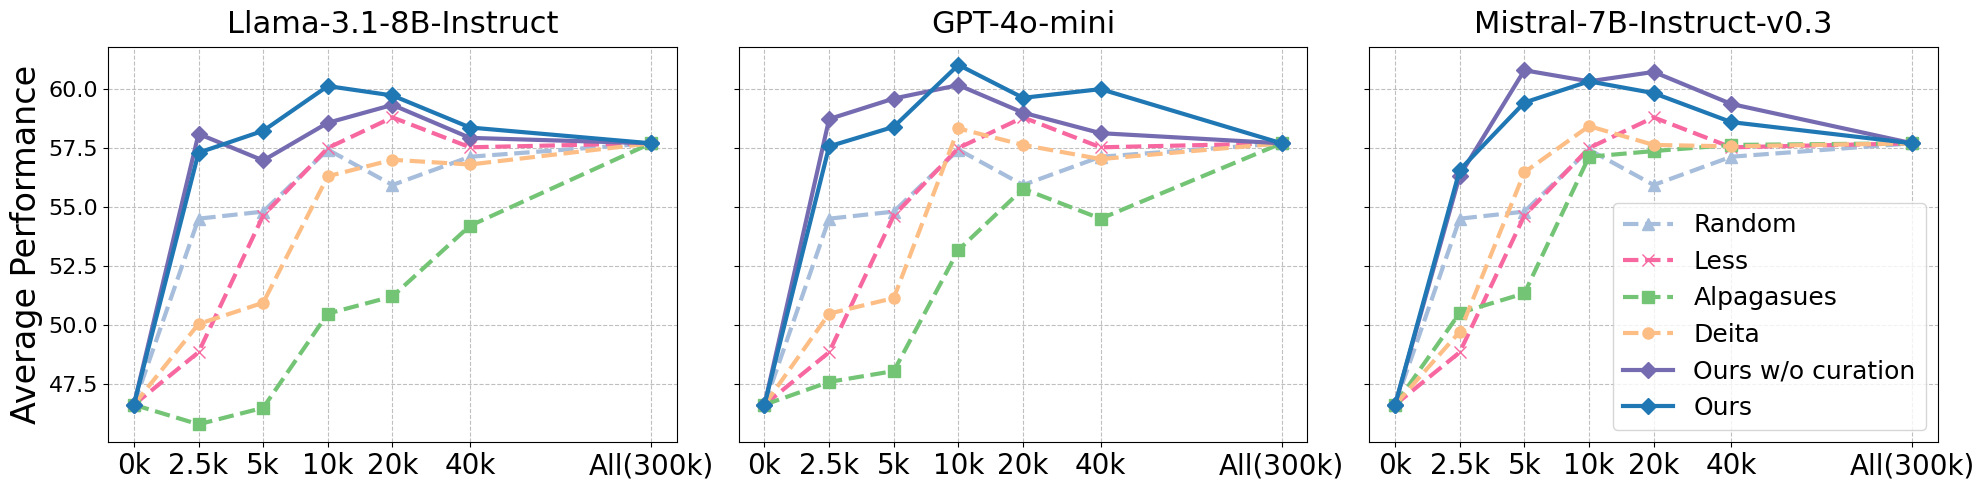

In [125]:
import os
import pandas as pd
import matplotlib.pyplot as plt

df_mean_rounded = pd.read_csv("data_scaling_final_average.csv", index_col=[0, 1])  
df_std_rounded = pd.read_csv("data_scaling_final_std.csv", index_col=[0, 1])

# x_labels = df_mean_rounded.columns.tolist()
x_labels = [0, 5, 10, 15, 20, 26, 40]

fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=True)

labeling_models = df_mean_rounded.index.get_level_values('labeling_model').unique()

for i, labeling_model in enumerate(labeling_models):
    df_subset = df_mean_rounded.xs(labeling_model, level='labeling_model')
    if labeling_model != 'Meta-Llama-3.1-8B-Instruct':
        df_subset_new = df_mean_rounded.xs('Meta-Llama-3.1-8B-Instruct', level='labeling_model')
        axes[i].plot(x_labels, df_subset_new.loc['random'], marker='^', label='Random', linewidth=3, color='#a6bddb', linestyle='--', markersize=8)
        axes[i].plot(x_labels, df_subset_new.loc['less'], marker='x', label='Less', linewidth=3, color='#f768a1', linestyle='--', markersize=8)

    for baseline_tag in df_subset.index:
        if baseline_tag == 'random':
            axes[i].plot(x_labels, df_subset.loc[baseline_tag], marker='^', label='Random', linewidth=3, color='#a6bddb', linestyle='--', markersize=8)
        elif baseline_tag == 'less':
            axes[i].plot(x_labels, df_subset.loc[baseline_tag], marker='x', label='Less', linewidth=3, color='#f768a1', linestyle='--', markersize=8)
        elif baseline_tag == 'label-filtered':
            axes[i].plot(x_labels, df_subset.loc[baseline_tag], marker='s', label='Alpagasues', linewidth=3, color='#74c476', linestyle='--', markersize=8)
        elif baseline_tag == 'diversity-filtered':
            axes[i].plot(x_labels, df_subset.loc[baseline_tag], marker='o', label='Deita', linewidth=3, color='#fdbe85', linestyle='--', markersize=8)
        elif baseline_tag == 'filtered':
            axes[i].plot(x_labels, df_subset.loc[baseline_tag], marker='D', label='Ours w/o curation', linewidth=3, color='#756bb1', linestyle='-', markersize=8)
        elif 'filtered-cured' in baseline_tag:
            axes[i].plot(x_labels, df_subset.loc[baseline_tag], marker='D', label='Ours', linewidth=3, color='#1f77b4', linestyle='-', markersize=8)


    xticks_labels = ['0k', '2.5k', '5k', '10k', '20k', '40k', 'All(300k)']
   
    if 'llama' in labeling_model.lower():
        axes[i].set_title(f'Llama-3.1-8B-Instruct', fontsize=22, pad=10)

    if 'gpt' in labeling_model.lower():
        axes[i].set_title(f'GPT-4o-mini', fontsize=22, pad=10)

    if 'mistral' in labeling_model.lower():
        axes[i].set_title(f'Mistral-7B-Instruct-v0.3', fontsize=22, pad=10)

    axes[i].set_xticks(x_labels)
    axes[i].set_xticklabels(xticks_labels, fontsize=20)
    axes[i].grid(True, which='both', linestyle='--', alpha=0.8)
    
    if i==2:
        axes[i].legend(loc='lower right', fontsize=18)

axes[0].set_ylabel('Average Performance', fontsize=24)
axes[0].tick_params(axis='y', labelsize=16)

plt.tight_layout()
plt.show()


### Figure: Data scaling efforts (with standard deviation)
- Data scaling efforts of baselines across various rating models. Base model: LLaMA-3.1-8B. The Y-axis is the performance of OpenLLM leaderboard. The X-axis means the \# samples used.

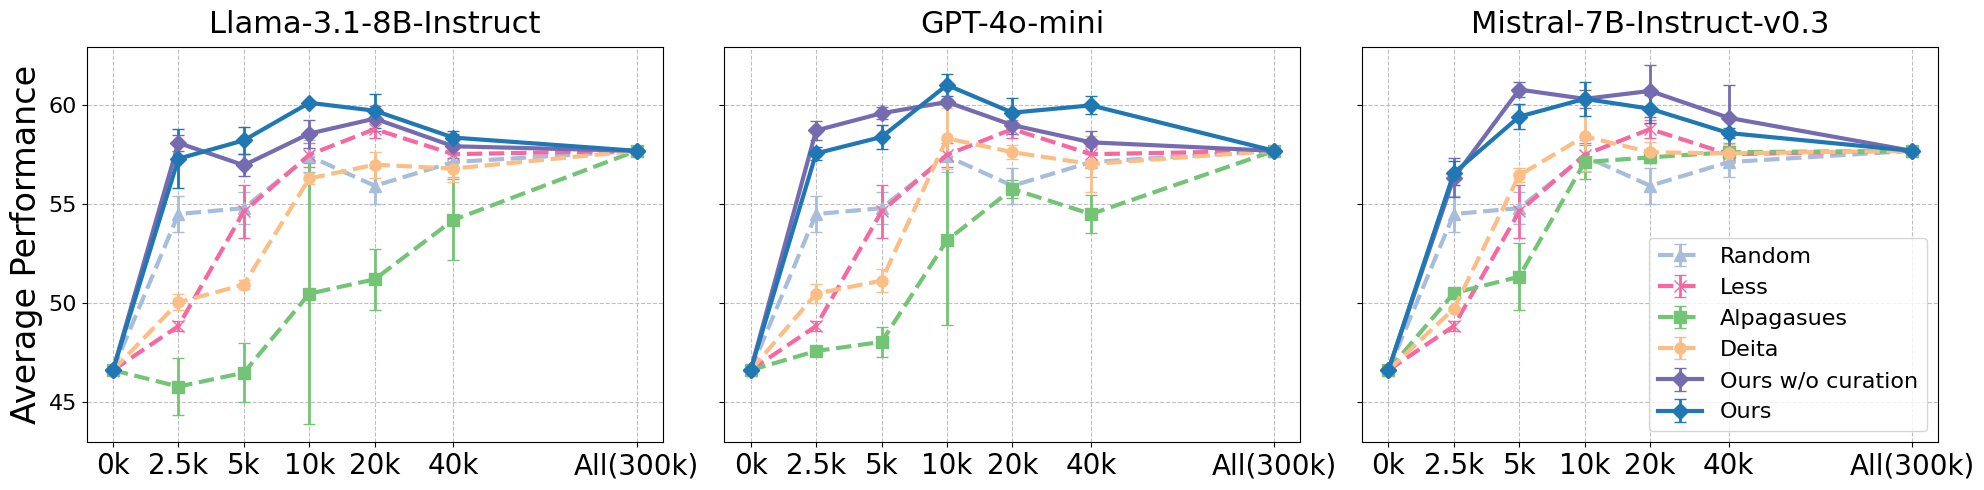

In [17]:
import os
import pandas as pd
import matplotlib.pyplot as plt

df_mean_rounded = pd.read_csv("./data_scale_results/data_scaling_final_average.csv", index_col=[0, 1])  
df_std_rounded = pd.read_csv("./data_scale_results/data_scaling_final_std.csv", index_col=[0, 1])

x_labels = [0, 5, 10, 15, 20, 26, 40]  
xticks_labels = ['0k', '2.5k', '5k', '10k', '20k', '40k', 'All(300k)']  # data scaling size

fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=True)

#  labeling models
labeling_models = df_mean_rounded.index.get_level_values('labeling_model').unique()

for i, labeling_model in enumerate(labeling_models):
    df_subset = df_mean_rounded.xs(labeling_model, level='labeling_model')
    df_std_subset = df_std_rounded.xs(labeling_model, level='labeling_model')
    
    # add the random less baseline for other labeling models since the random less is independent of labeling models
    if labeling_model != 'Meta-Llama-3.1-8B-Instruct':
        df_subset_new = df_mean_rounded.xs('Meta-Llama-3.1-8B-Instruct', level='labeling_model')
        df_std_new = df_std_rounded.xs('Meta-Llama-3.1-8B-Instruct', level='labeling_model')
        axes[i].errorbar(x_labels, df_subset_new.loc['random'], yerr=df_std_new.loc['random'],
                         marker='^', label='Random', linewidth=3, color='#a6bddb', linestyle='--', markersize=8, capsize=4, elinewidth=2)
        axes[i].errorbar(x_labels, df_subset_new.loc['less'], yerr=df_std_new.loc['less'],
                         marker='x', label='Less', linewidth=3, color='#f768a1', linestyle='--', markersize=8, capsize=4, elinewidth=2)

    # curves for baselines with errorbar
    for baseline_tag in df_subset.index:
        if baseline_tag == 'random':
            axes[i].errorbar(x_labels, df_subset.loc[baseline_tag], yerr=df_std_subset.loc[baseline_tag],
                             marker='^', label='Random', linewidth=3, color='#a6bddb', linestyle='--', markersize=8, capsize=4, elinewidth=2)
        elif baseline_tag == 'less':
            axes[i].errorbar(x_labels, df_subset.loc[baseline_tag], yerr=df_std_subset.loc[baseline_tag],
                             marker='x', label='Less', linewidth=3, color='#f768a1', linestyle='--', markersize=8, capsize=4, elinewidth=2)
        elif baseline_tag == 'label-filtered':
            axes[i].errorbar(x_labels, df_subset.loc[baseline_tag], yerr=df_std_subset.loc[baseline_tag],
                             marker='s', label='Alpagasues', linewidth=3, color='#74c476', linestyle='--', markersize=8, capsize=4, elinewidth=2)
        elif baseline_tag == 'diversity-filtered':
            axes[i].errorbar(x_labels, df_subset.loc[baseline_tag], yerr=df_std_subset.loc[baseline_tag],
                             marker='o', label='Deita', linewidth=3, color='#fdbe85', linestyle='--', markersize=8, capsize=4, elinewidth=2)
        elif baseline_tag == 'filtered':
            axes[i].errorbar(x_labels, df_subset.loc[baseline_tag], yerr=df_std_subset.loc[baseline_tag],
                             marker='D', label='Ours w/o curation', linewidth=3, color='#756bb1', linestyle='-', markersize=8, capsize=4, elinewidth=2)
        elif 'filtered-cured' in baseline_tag:
            axes[i].errorbar(x_labels, df_subset.loc[baseline_tag], yerr=df_std_subset.loc[baseline_tag],
                             marker='D', label='Ours', linewidth=3, color='#1f77b4', linestyle='-', markersize=8, capsize=4, elinewidth=2)

    if 'llama' in labeling_model.lower():
        axes[i].set_title(f'Llama-3.1-8B-Instruct', fontsize=22, pad=10)

    if 'gpt' in labeling_model.lower():
        axes[i].set_title(f'GPT-4o-mini', fontsize=22, pad=10)

    if 'mistral' in labeling_model.lower():
        axes[i].set_title(f'Mistral-7B-Instruct-v0.3', fontsize=22, pad=10)

    axes[i].set_xticks(x_labels)
    axes[i].set_xticklabels(xticks_labels, fontsize=20)
    axes[i].grid(True, which='both', linestyle='--', alpha=0.8)
    
    if i == 2:
        axes[i].legend(loc='lower right', fontsize=16)

axes[0].set_ylabel('Average Performance', fontsize=24)
axes[0].tick_params(axis='y', labelsize=16)

plt.tight_layout()
plt.show()


## Plot the stability of curation

### Figure: Maximum performance gap across various rating models. Base model: LLaMA-3.1-8B.
- explore the impact of score curation using different rating models
- with variance from three random model seeds

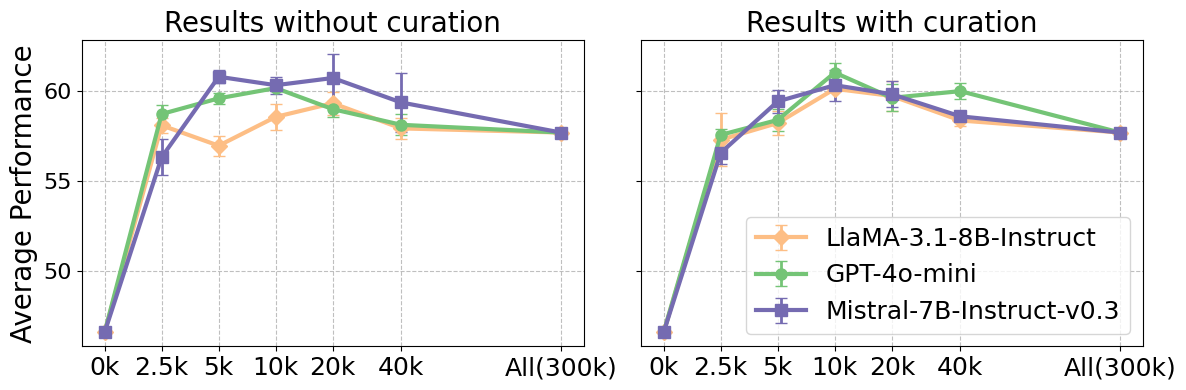

In [7]:
import os
import pandas as pd
import matplotlib.pyplot as plt


# load results
df_mean_rounded = pd.read_csv("./data_scale_results/data_scaling_final_average.csv", index_col=[0, 1])  
df_std_rounded = pd.read_csv("./data_scale_results/data_scaling_final_std.csv", index_col=[0, 1])

x_labels = [0, 5, 10, 15, 20, 26, 40]  # data scale size
xticks_labels = ['0k', '2.5k', '5k', '10k', '20k', '40k', 'All(300k)'] 

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# labeling models
labeling_models = df_mean_rounded.index.get_level_values('labeling_model').unique()

for labeling_model in labeling_models:
    df_subset = df_mean_rounded.xs(labeling_model, level='labeling_model')
    df_std_subset = df_std_rounded.xs(labeling_model, level='labeling_model')  # standard deviation

    if 'llama' in labeling_model.lower():
        axes[0].errorbar(x_labels, df_subset.loc['filtered'], yerr=df_std_subset.loc['filtered'],
                         marker='D', label='LlaMA-3.1-8B-Instruct', color='#fdbe85', linewidth=3, 
                         linestyle='-', markersize=8, capsize=4,elinewidth=2)  # elinewidth 

    if 'gpt' in labeling_model.lower():
        axes[0].errorbar(x_labels, df_subset.loc['filtered'], yerr=df_std_subset.loc['filtered'],
                         marker='o', label='GPT-4o-mini', color='#74c476', linewidth=3, 
                         linestyle='-', markersize=8, capsize=4,elinewidth=2)

    if 'mistral' in labeling_model.lower():
        axes[0].errorbar(x_labels, df_subset.loc['filtered'], yerr=df_std_subset.loc['filtered'],
                         marker='s', label='Mistral-7B-v0.3', color='#756bb1',  linewidth=3, 
                         linestyle='-', markersize=8, capsize=4,elinewidth=2)
        

# filtered-cured curve
for labeling_model in labeling_models:
    df_subset = df_mean_rounded.xs(labeling_model, level='labeling_model')
    df_std_subset = df_std_rounded.xs(labeling_model, level='labeling_model')  # standard deviation

    filtered_cured_tags = [tag for tag in df_subset.index if 'filtered-cured' in tag]

    if 'llama' in labeling_model.lower():
        axes[1].errorbar(x_labels, df_subset.loc[filtered_cured_tags[0]], yerr=df_std_subset.loc[filtered_cured_tags[0]],
                         marker='D', label='LlaMA-3.1-8B-Instruct', color='#fdbe85', linewidth=3, 
                         linestyle='-', markersize=8, capsize=4,elinewidth=2)

    if 'gpt' in labeling_model.lower():
        axes[1].errorbar(x_labels, df_subset.loc[filtered_cured_tags[0]], yerr=df_std_subset.loc[filtered_cured_tags[0]],
                         marker='o', label='GPT-4o-mini', color='#74c476', linewidth=3, 
                         linestyle='-', markersize=8, capsize=4,elinewidth=2)

    if 'mistral' in labeling_model.lower():
        axes[1].errorbar(x_labels, df_subset.loc[filtered_cured_tags[0]], yerr=df_std_subset.loc[filtered_cured_tags[0]],
                         marker='s', label='Mistral-7B-Instruct-v0.3', color='#756bb1',  linewidth=3, 
                         linestyle='-', markersize=8, capsize=4,elinewidth=2)
        

axes[0].set_title('Results without curation', fontsize=20)
axes[0].set_xticks(x_labels)
axes[0].set_xticklabels(xticks_labels, fontsize=18)
axes[0].set_ylabel('Average Performance', fontsize=20)
axes[0].tick_params(axis='y', labelsize=16)
axes[0].grid(True, which='both', linestyle='--', alpha=0.8)

axes[1].set_title('Results with curation', fontsize=20)
axes[1].set_xticks(x_labels)
axes[1].set_xticklabels(xticks_labels, fontsize=18)
axes[1].grid(True, which='both', linestyle='--', alpha=0.8)

axes[1].legend(loc='lower right', fontsize=18)

plt.tight_layout()
plt.show()



### Table: Maximum performance gap across various rating models. Base model: LLaMA-3.1-8B.
- explore the impact of score curation using different rating models

In [14]:
import pandas as pd


x_labels = [0, 5, 10, 15, 20, 26, 40]  #axis x

labeling_models = df_mean_rounded.index.get_level_values('labeling_model').unique()

filtered_gap = []
for i, x_label in enumerate(x_labels):
    values = []
    for labeling_model in labeling_models:
        df_subset = df_mean_rounded.xs(labeling_model, level='labeling_model')
        values.append(df_subset.loc['filtered'].iloc[i])
    
    gap = round(float(max(values) - min(values)), 4)
    filtered_gap.append(gap)

filtered_cured_gap = []
for i, x_label in enumerate(x_labels):
    values = []
    for labeling_model in labeling_models:
        df_subset = df_mean_rounded.xs(labeling_model, level='labeling_model')
        filtered_cured_tags = [tag for tag in df_subset.index if 'filtered-cured' in tag]
        values.append(df_subset.loc[filtered_cured_tags[0]].iloc[i])
    
    gap = round(float(max(values) - min(values)), 4)
    filtered_cured_gap.append(gap)

print("Filtered gaps:", filtered_gap)
print("Filtered-cured gaps:", filtered_cured_gap)

filtered_gap_avg = sum(filtered_gap) / len(filtered_gap)
filtered_cured_gap_avg = sum(filtered_cured_gap) / len(filtered_cured_gap)

print("Filtered gap average value:", round(filtered_gap_avg, 3))
print("Filtered-cured gap average value:", round(filtered_cured_gap_avg, 3))


Filtered gaps: [0.0, 2.4, 3.83, 1.76, 1.73, 1.44, 0.0]
Filtered-cured gaps: [0.0, 1.0, 1.2, 0.9, 0.2, 1.63, 0.0]
Filtered gap average value: 1.594
Filtered-cured gap average value: 0.704
